# Plots for ECS 2022 Submission

In [ ]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable


eSOH_DIR = "./data/esoh/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/"
res_DIR = "./data/results/"
# %matplotlib widget

In [ ]:
plt.rcParams["lines.markersize"] = 5
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["legend.frameon"] = False
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.color"] = (0.8, 0.8, 0.8)
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.max_open_warning']=False

In [ ]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

In [ ]:
parameter_values.search("Li")

In [ ]:
def split_long_string(title, max_words=None):
    """Get title in a nice format"""
    max_words = max_words or pybamm.settings.max_words_in_line
    words = title.split()
    # Don't split if fits on one line, don't split just for units
    if len(words) <= max_words or words[max_words].startswith("["):
        return title
    else:
        first_line = (" ").join(words[:max_words])
        second_line = (" ").join(words[max_words:])
        return first_line + "\n" + second_line

In [ ]:
def cycle_adaptive_simulation(model, parameter_values, experiment,SOC_0=1, save_at_cycles=None):
    experiment_one_cycle = pybamm.Experiment(
        experiment.operating_conditions_cycles[:1],
        termination=experiment.termination_string,
        cccv_handling=experiment.cccv_handling,
    )
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    c_n_max = parameter_values.evaluate(param.c_n_max)
    c_p_max = parameter_values.evaluate(param.c_p_max)
    n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
                "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            
        }
    )

    sim_ode = pybamm.Simulation(
        model, experiment=experiment_one_cycle, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol0 = sim_ode.solve(initial_soc=SOC_0)
    model = sim_ode.solution.all_models[0]
    cap0 = sol0.summary_variables["Capacity [A.h]"]

    def sol_to_y(sol, loc="end"):
        if loc == "start":
            pos = 0
        elif loc == "end":
            pos = -1
        model = sol.all_models[0]
        n_Li = sol["Total lithium in particles [mol]"].data[pos].flatten()
        Cn = sol["Negative electrode capacity [A.h]"].data[pos].flatten()
        Cp = sol["Positive electrode capacity [A.h]"].data[pos].flatten()
        # y = np.concatenate([n_Li, Cn, Cp])
        y = n_Li
        for var in model.initial_conditions:
            if var.name not in [
                "X-averaged negative particle concentration",
                "X-averaged positive particle concentration",
                "Discharge capacity [A.h]",
            ]:
                value = sol[var.name].data
                if value.ndim == 1:
                    value = value[pos]
                elif value.ndim == 2:
                    value = value[:, pos]
                elif value.ndim == 3:
                    value = value[:, :, pos]
                y = np.concatenate([y, value.flatten()])
        return y

    def y_to_sol(y, esoh_sim, model):
        n_Li = y[0]
        Cn = C_over_eps_n * y[1]
        Cp = C_over_eps_p * y[2]

        esoh_sol = esoh_sim.solve(
            [0],
            inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
        )
        esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
        ics = {}
        x_100 = esoh_sol["x_100"].data[0]
        y_100 = esoh_sol["y_100"].data[0]
        x_0 = esoh_sol["x_0"].data[0]
        y_0 = esoh_sol["y_0"].data[0]
        start = 1
        for var in model.initial_conditions:
            if var.name == "X-averaged negative particle concentration":
                ics[var.name] = ((x_100-x_0)*SOC_0+x_0) * np.ones((model.variables[var.name].size, 2))
            elif var.name == "X-averaged positive particle concentration":
                ics[var.name] = ((y_100-y_0)*SOC_0+y_0) * np.ones((model.variables[var.name].size, 2))
            elif var.name == "Discharge capacity [A.h]":
                ics[var.name] = np.zeros(1)
            else:
                end = start + model.variables[var.name].size
                ics[var.name] = y[start:end, np.newaxis]
                start = end
        model.set_initial_conditions_from(ics)
        return pybamm.Solution(
            [np.array([0])],
            model.concatenated_initial_conditions.evaluate()[:, np.newaxis],
            model,
            {},
        )

    def dydt(t, y):
        if y[0] < 0 or y[1] < 0 or y[2] < 0:
            return 0 * y

        # print(t)
        # Set up based on current value of y
        y_to_sol(
            y,
            esoh_sim,
            sim_ode.op_conds_to_built_models[
                experiment_one_cycle.operating_conditions[0]["electric"]
            ],
        )

        # Simulate one cycle
        sol = sim_ode.solve()

        dy = sol_to_y(sol) - y

        return dy

    if experiment.termination == {}:
        event = None
    else:

        def capacity_cutoff(t, y):
            sol = y_to_sol(y, esoh_sim, model)
            cap = pybamm.make_cycle_solution([sol], esoh_sim, True)[1]["Capacity [A.h]"]
            return cap / cap0 - experiment_one_cycle.termination["capacity"][0] / 100

        capacity_cutoff.terminal = True

    num_cycles = len(experiment.operating_conditions_cycles)
    if save_at_cycles is None:
        t_eval = np.arange(1, num_cycles + 1)
    elif save_at_cycles == -1:
        t_eval = None
    else:
        t_eval = np.arange(1, num_cycles + 1, save_at_cycles)
    y0 = sol_to_y(sol0, loc="start")
    timer = pybamm.Timer()
    sol = solve_ivp(
        dydt,
        [1, num_cycles],
        y0,
        t_eval=t_eval,
        events=capacity_cutoff,
        first_step=10,
        method="RK23",
        atol=1e-2,
        rtol=1e-2,
    )
    time = timer.time()

    all_sumvars = []
    for idx in range(sol.y.shape[1]):
        fullsol = y_to_sol(sol.y[:, idx], esoh_sim, model)
        sumvars = pybamm.make_cycle_solution([fullsol], esoh_sim, True)[1]
        all_sumvars.append(sumvars)

    all_sumvars_dict = {
        key: np.array([sumvars[key] for sumvars in all_sumvars])
        for key in all_sumvars[0].keys()
    }
    all_sumvars_dict["Cycle number"] = sol.t
    
    all_sumvars_dict["cycles evaluated"] = sol.nfev
    all_sumvars_dict["solution time"] = time
    
    return all_sumvars_dict

In [ ]:
def plot(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_0", "y_0", "x_100", "y_100", "C_n", "C_p"]
    # esoh_vars = ["Capacity [A.h]", "Loss of lithium inventory [%]",
    #              "Loss of active material in negative electrode [%]",
    #              "Loss of active material in positive electrode [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
#         ax.scatter(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],color="r")
    #     ax.plot(long_sol.summary_variables[name],"b-")
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    # fig.subplots_adjust(bottom=0.4)
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="lower center", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

def plot1(all_sumvars_dict,esoh_data):
    esoh_vars = ["Capacity [A.h]","n_Li"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    fig, axes = plt.subplots(2,1,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        ax.set_xlabel("Cycle number")
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="upper right", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig
def plotc(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([4,6])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [ ]:
cell = 1

## Load eSOH Data and OCV Data

In [ ]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
dfe_0=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
# Remove first RPT
dfe = dfe.drop(dfe.index[0])
dfe = dfe.reset_index(drop=True)
dfe['N']=dfe['N']-dfe['N'][0]
N =dfe.N.unique()
N_0 = dfe_0.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

In [ ]:
irr_exp = []
# print('Irreversible Expansion')
for i in range(len(N_0)):
    dfo = dfo_0[dfo_0['N']==N_0[i]]
    # print(min(dfo['E']))
    irr_exp.append(min(dfo['E']))
dfe_0['irr_exp']=irr_exp

rev_exp = []
print('Reversible Expansion')
for i in range(len(N_0)):
    dfo = dfo_0[dfo_0['N']==N_0[i]]
    # print(max(dfo['E'])-min(dfo['E']))
    rev_exp.append(max(dfo['E'])-min(dfo['E']))
dfe_0['rev_exp']=rev_exp
print(dfe_0['rev_exp'].iloc[-1])
print(dfe_0['Cap'].iloc[-1])

In [ ]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
if cell_no=='01':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " until 3V"
    # eps_n_data = 0.6234
    # eps_p_data = 0.4542
elif cell_no=='13':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " for 150 min"

In [ ]:
dfe.N.iloc[-1]

In [ ]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [ ]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

In [ ]:
parameter_values = get_parameter_values()

parameter_values.update(
    {
        # ACC
        # "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        # "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # ECS
        "Positive electrode LAM constant proportional term [s-1]": 4.815555555555556e-06,
        "Negative electrode LAM constant proportional term [s-1]": 5.360555555555556e-05,
        # "SEI kinetic rate constant [m.s-1]": 2.33728e-16,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment, save_at_cycles=2)

In [ ]:
sim_des = '_ECS_sei'
# sim_des = '_ACC'
d = all_sumvars_dict
df = pd.DataFrame.from_dict(d, )
df.to_csv(res_DIR + "cell_"+ cell_no + sim_des+"_accl.csv")

In [ ]:
# fig = plot(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [ ]:
# fig = plot1(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_cap_new.png')

In [ ]:
fig = plotc(all_sumvars_dict,dfe);
fig.savefig(fig_DIR +'pred_sim'+sim_des+'_'+cell_no+'_eSOHC.png')

In [ ]:
def plotcpcn(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig = plt.figure(figsize=[6,4])
    ax1 = plt.subplot(1,2,1)
    name="C_n"
    ax1.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
    ax1.plot(esoh_data["N"],esoh_data[name],"kx",label='_nolegend_')
    name="C_p"
    ax1.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"bo")
    ax1.plot(esoh_data["N"],esoh_data[name],"kx",label='_nolegend_')
    ax1.set_title("Electrode Capacity [Ah]")
    ax1.set_ylim([4,6])
    ax1.set_xlabel("Cycle number")
    ax1.legend(["$C_n$"] + ["$C_p$"])
    fig.tight_layout()
    return fig

In [ ]:
fig = plotcpcn(all_sumvars_dict,dfe);
fig.savefig(fig_DIR +'pred_sim'+sim_des+'_'+cell_no+'_eCap.png')

In [ ]:
# df.columns

In [ ]:
def plotlossli(all_sumvars_dict,esoh_data):
    esoh_vars = ["Total lithium lost [mol]", "Loss of lithium to SEI [mol]", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig = plt.figure(figsize=[6,4])
    ax = plt.subplot(1,1,1)
    name="Total lithium lost [mol]"
    name2 = "Total lithium [mol]"
    # ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
    ax.plot(all_sumvars_dict["Cycle number"],(all_sumvars_dict[name]/all_sumvars_dict[name2][0])*100,"ro")
    # ax.plot(esoh_data["N"],esoh_data[name],"kx",label='_nolegend_')
    name="Loss of lithium to SEI [mol]"
    # ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"bo")
    ax.plot(all_sumvars_dict["Cycle number"],(all_sumvars_dict[name]/all_sumvars_dict[name2][0])*100,"bo")
    # ax.plot(esoh_data["N"],esoh_data[name],"kx",label='_nolegend_')
    # ax.set_title("Loss of Lithium [mol]")
    ax.set_title("LLI [%]")
    # ax.set_ylim([4,6])
    ax.set_xlabel("Cycle number")
    ax.legend(["Total loss of Li"] + ["Loss loss Li due to SEI"])
    fig.tight_layout()
    return fig

In [ ]:
fig = plotlossli(all_sumvars_dict,dfe);
fig.savefig(fig_DIR +'pred_sim'+sim_des+'_'+cell_no+'_lossli.png')

In [ ]:
def plotlam(all_sumvars_dict,esoh_data):
    esoh_vars = ["Total lithium lost [mol]", "Loss of lithium to SEI [mol]", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig = plt.figure(figsize=[6,4])
    ax = plt.subplot(1,1,1)
    name="Loss of active material in negative electrode [%]"
    ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
    # ax.plot(esoh_data["N"],esoh_data[name],"kx",label='_nolegend_')
    name="Loss of active material in positive electrode [%]"
    ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"bo")
    # ax.plot(esoh_data["N"],esoh_data[name],"kx",label='_nolegend_')
    # ax.set_title("Loss of Lithium [mol]")
    ax.set_title("LAM [%]")
    # ax.set_ylim([4,6])
    ax.set_xlabel("Cycle number")
    ax.legend(["NE"] + ["PE"])
    fig.tight_layout()
    return fig

In [ ]:
fig = plotlam(all_sumvars_dict,dfe);
fig.savefig(fig_DIR +'pred_sim'+sim_des+'_'+cell_no+'_LAM.png')

In [ ]:
dfe["n_Li"][0]

In [ ]:
# print(df['Change in total lithium in negative electrode [mol]'].iloc[-1])
print(df['Total lithium lost to side reactions [mol]'].iloc[-1])
# print(df[''].iloc[-1])
print(df['Loss of lithium to SEI [mol]'].iloc[-1])
print(df['Total lithium lost from particles [mol]'].iloc[-1])
print(df['Total lithium lost [mol]'].iloc[-1])
print(df['Total lithium in particles [mol]'].iloc[-1])
print(df['Total lithium in positive electrode [mol]'].iloc[-1])
print(df['Total lithium in negative electrode [mol]'].iloc[-1])

# Parameter Fitting

In [ ]:
cycles = np.array(dfe['N'].astype('int'))
cycles=cycles-1
cycles[0]=cycles[0]+1
cycles
dfe['N_mod'] = cycles

In [ ]:
def plot_comp(all_sumvars_dict_0,all_sumvars_dict_1,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict_1["Cycle number"],all_sumvars_dict_1[name],"bo")
        ax.plot(all_sumvars_dict_0["Cycle number"],all_sumvars_dict_0[name],"ro")
        # ax.plot(all_sumvars_dict_1["Cycle number"],all_sumvars_dict_1[name],"bo")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.axvline(x = all_sumvars_dict_0["Cycle number"][-1], color = 'm', label = 'axvline - full height')
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Pred"]+["Train"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5, -0.05], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

## List of Initial Conditions

In [ ]:
ic = 0
blam_p = [2e-2/3600, 4e-6, 1e-5,1e-6]
blam_n = [2e-1/3600, 3e-5, 2e-5,7e-5]
k_sei= [1.6e-16,1.5e-16,1.7e-16,1.3e-16]

In [ ]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Cap"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    # variables = ["Capacity [A.h]", "C_n"]
    weights = [1,1,5,5]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,expt):
    parameter_values = get_parameter_values()
    parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]":  x[2]*k_sei[ic],
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "EC diffusivity [m2.s-1]": 2e-18,
            "Positive electrode LAM constant exponential term": 2,
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
        },
        check_already_exists=False,
    )
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    return cycle_adaptive_simulation(spm, parameter_values, expt,save_at_cycles=1)
def prediction_error(x,data,expt):
    try:
        model = simulate(x,expt,timeout=60)
        out = multi_objective(pd.DataFrame(model), data)
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out = 10*np.ones_like(np.concatenate([np.array(data['Cap'])]*4))
        print(f"x={x}, norm={np.linalg.norm(out)}")
        return out
    return out
def train_model(data,expt):
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0,1.0])
    # print(prediction_error(x0))
    soln_dfols = dfols.solve(prediction_error, x0,args=(data,expt), rhoend=1e-3)
    print(timer.time())
    return soln_dfols
def sim_train(dfe,experiment,df,train_len):
    data_train = dfe.iloc[:train_len]
    experiment_train = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/50")
        ] *data_train.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    soln_dfols = train_model(data_train,experiment_train)
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['train_len'][train_len-3]=train_len
    df['x_0'][train_len-3]=round(xsol[0],4)
    df['x_1'][train_len-3]=round(xsol[1],4)
    df['x_2'][train_len-3]=round(xsol[2],4)
    # df['obj'][train_len-3]=soln_dfols.f
    try:
        sol_out = simulate(soln_dfols.x,experiment_train,timeout = 60)
        sol_full = simulate(soln_dfols.x,experiment,timeout = 60)
        df['obj'][train_len-3]= np.linalg.norm(prediction_error(soln_dfols.x,data_train,experiment_train))
        df['obj_full'][train_len-3] = np.linalg.norm(prediction_error(soln_dfols.x,dfe,experiment))
        fig = plot_comp(sol_out,sol_full,dfe);
        return df,fig
    except:
        print("Train Len = "+str(train_len)+" failed")
        fig, axes = plt.subplots(3,2,figsize=(7,7))
        return df,fig

In [ ]:
# df_x = pd.DataFrame(columns=['train_len','x_0','x_1','x_2','obj','obj_full'], index=range(len(N)+1-3))

In [ ]:
# sim_des = "ic_"+str(ic)
# timer1 = pybamm.Timer()
# for train_len in range(3,len(N)):
#     print("Train Length = {0}".format(train_len))
#     df_x,fig = sim_train(dfe,experiment,df_x,train_len)
#     df_x.to_csv(res_DIR + "fit_train_pred_"+sim_des+".csv")
#     fig.suptitle('Train Length = '+str(train_len),fontsize=16,y=1.02)
#     fig.savefig(fig_DIR + "fit_train_pred_"+ sim_des+"_"+str(train_len) +"_eSOHC.png",bbox_inches='tight')
#     print('Total Time')
#     print(timer1.time())

## Generate figures from solutions

In [ ]:
sim_des = "ic_0"
df_x = pd.read_csv(res_DIR + "fit_train_pred_"+sim_des+".csv").drop(['Unnamed: 0'],axis=1)
df_x

In [ ]:
train_len = 10
data_train = dfe.iloc[:train_len]
print(train_len)
x = [df_x['x_0'][train_len-3],df_x['x_1'][train_len-3],df_x['x_2'][train_len-3]]
print(x)

In [ ]:
train_len = 3
data_train = dfe.iloc[:train_len]
print(train_len)
x = [df_x['x_0'][train_len-3],df_x['x_1'][train_len-3],df_x['x_2'][train_len-3]]
experiment_train = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/50")
        ] *data_train.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
sol_out_0 = simulate(x,experiment_train,timeout = 30)

In [ ]:
sol_full_0 = simulate(x,experiment,timeout = 30)

In [ ]:
# train_len = 3
# data_train = dfe.iloc[:train_len]
# print(train_len)
# x = [df_x['x_0'][train_len-3],df_x['x_1'][train_len-3],df_x['x_2'][train_len-3]]
# experiment_train = pybamm.Experiment(
#         [
#             ("Discharge at "+c_rate_d+dis_set,
#             "Rest for 5 min",
#             "Charge at "+c_rate_c+" until 4.2V", 
#             "Hold at 4.2V until C/50")
#         ] *data_train.N.iloc[-1],
#         termination="50% capacity",
#     #     cccv_handling="ode",
#     )
# sol_out_0 = simulate(x,experiment_train,timeout = 30)
# sol_full_0 = simulate(x,experiment,timeout = 30)
train_len = 5
data_train = dfe.iloc[:train_len]
print(train_len)
x = [df_x['x_0'][train_len-3],df_x['x_1'][train_len-3],df_x['x_2'][train_len-3]]
experiment_train = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/50")
        ] *data_train.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
sol_out_1 = simulate(x,experiment_train,timeout = 30)
sol_full_1 = simulate(x,experiment,timeout = 30)
# plot_comp(sol_out,sol_full,dfe)


In [ ]:
esoh_data = dfe_0
train_0 = sol_out_0.copy() 
train_0["Cycle number"] = train_0["Cycle number"] + dfe_0['N'][1]
pred_0 = sol_full_0.copy()
pred_0["Cycle number"] = pred_0["Cycle number"] + dfe_0['N'][1]
train_1 = sol_out_1.copy() 
train_1["Cycle number"] = train_1["Cycle number"] + dfe_0['N'][1]
pred_1 = sol_full_1.copy()
pred_1["Cycle number"] = pred_1["Cycle number"] + dfe_0['N'][1]
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
yl = ["$x_{100}$", "$y_{0}$", "$C_n$", "$C_p$", "Capacity [A.h]", "LLI [%]"]
esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
param = pybamm.LithiumIonParameters()
esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
fig, axes = plt.subplots(3,2,figsize=(7,7))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.plot(train_0["Cycle number"],train_0[name],"b^",markevery=10)
    ax.plot(pred_0["Cycle number"][len(train_0["Cycle number"]):],pred_0[name][len(train_0["Cycle number"]):],"b1",markevery=10)
    ax.plot(train_1["Cycle number"],train_1[name],"r^",markevery=10)
    ax.plot(pred_1["Cycle number"][len(train_1["Cycle number"]):],pred_1[name][len(train_1["Cycle number"]):],"r1",markevery=10)
    # ax.plot(pred_0["Cycle number"],pred_0[name],"bo")
    ax.plot(esoh_data["N"],esoh_data[name],"ko")
    ax.axvline(x = train_0["Cycle number"][-1], color = 'b', label = 'axvline - full height')
    ax.axvline(x = train_1["Cycle number"][-1], color = 'r', label = 'axvline - full height')
    # ax.set_title(split_long_string(name))
    ax.set_ylabel(yl[k])
    if k==2 or k==3:
        ax.set_ylim([4,6])
    if k>3:
        ax.set_xlabel("Cycle number")
fig.legend(["Train Length =3"]+["Prediction Length =3"] + ["Train Length = 5"]+["Prediction Length = 5"], loc="lower center",bbox_to_anchor=[0.5, -0.08], ncol=2, fontsize=11)
fig.tight_layout()
# fig.savefig(fig_DIR + "ECS_fig1.png",bbox_inches='tight')


In [ ]:
esoh_data = dfe_0
train_0 = sol_out_0.copy() 
train_0["Cycle number"] = train_0["Cycle number"] + dfe_0['N'][1]
pred_0 = sol_full_0.copy()
pred_0["Cycle number"] = pred_0["Cycle number"] + dfe_0['N'][1]
train_1 = sol_out_1.copy() 
train_1["Cycle number"] = train_1["Cycle number"] + dfe_0['N'][1]
pred_1 = sol_full_1.copy()
pred_1["Cycle number"] = pred_1["Cycle number"] + dfe_0['N'][1]
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
esoh_vars = ["x_100", "y_0", "C_n", "C_p"]
yl = ["$x_{100}$", "$y_{0}$", "$C_n$", "$C_p$", "Capacity [A.h]", "LLI [%]"]
esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
param = pybamm.LithiumIonParameters()
esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
fig, axes = plt.subplots(2,2,figsize=(7,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.plot(train_0["Cycle number"],train_0[name],"b^",markevery=20)
    ax.plot(pred_0["Cycle number"][len(train_0["Cycle number"]):],pred_0[name][len(train_0["Cycle number"]):],"b1",markevery=10)
    ax.plot(train_1["Cycle number"],train_1[name],"r^",markevery=10)
    ax.plot(pred_1["Cycle number"][len(train_1["Cycle number"]):],pred_1[name][len(train_1["Cycle number"]):],"r1",markevery=10)
    # ax.plot(pred_0["Cycle number"],pred_0[name],"bo")
    ax.plot(esoh_data["N"],esoh_data[name],"ko")
    ax.axvline(x = train_0["Cycle number"][-1], color = 'b', label = 'axvline - full height')
    ax.axvline(x = train_1["Cycle number"][-1], color = 'r', label = 'axvline - full height')
    # ax.set_title(split_long_string(name))
    ax.set_ylabel(yl[k])
    if k==0:
        ax.set_ylim([0.8,0.86])
    if k==1:
        ax.set_ylim([0.6,0.9])
    if k==2 or k==3:
        ax.set_ylim([4,6.2])
    if k>1:
        ax.set_xlabel("Cycle number")
fig.legend(["Train Length =3"]+["Prediction Length =3"] + ["Train Length = 5"]+["Prediction Length = 5"], loc="lower center",bbox_to_anchor=[0.5, -0.08], ncol=2, fontsize=11)
fig.tight_layout()
fig.savefig(fig_DIR + "ECS_slide2.png",bbox_inches='tight')


In [ ]:
len(pred_0["C_n"])

## Plot Tuned Parameters

In [ ]:
colors = ['b','r','g','y']

# Reversible Expansion

In [ ]:
ic=0

In [ ]:
experiment_rev_exp = pybamm.Experiment(
    [
        "Charge at "+c_rate_c+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)

In [ ]:
dis_set = " until 3V"
c_rate_d = 'C/20'
c_rate_c = 'C/20'
experiment_rev_exp = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 60 min",
        "Charge at "+c_rate_c+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)
Ns = np.insert(N[1:]-1,0,0)

In [ ]:
def rev_exp(cyc_no,eSOH):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.c_n_max)
    c_p_max = parameter_values.evaluate(param.c_p_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            
        }
    )

    sim_ode = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_ode.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    return exp_t

In [ ]:
train_len = 3
print(train_len)
rev_exp_0 = []
for cyc_no in range(len(N)):
    exp = rev_exp(cyc_no,sol_full_0)
    # print(cyc_no)
    # print(max(abs(exp)))
    rev_exp_0.append(max(abs(exp)))
train_len = 5
print(train_len)
rev_exp_1 = []
for cyc_no in range(len(N)):
    exp = rev_exp(cyc_no,sol_full_1)
    # print(cyc_no)
    # print(max(abs(exp)))
    rev_exp_1.append(max(abs(exp)))


In [ ]:
# pred_0.keys()

In [ ]:
esoh_data = dfe_0
train_0 = sol_out_0.copy() 
train_0["Cycle number"] = train_0["Cycle number"] + dfe_0['N'][1]
pred_0 = sol_full_0.copy()
pred_0["Cycle number"] = pred_0["Cycle number"] + dfe_0['N'][1]
train_1 = sol_out_1.copy() 
train_1["Cycle number"] = train_1["Cycle number"] + dfe_0['N'][1]
pred_1 = sol_full_1.copy()
pred_1["Cycle number"] = pred_1["Cycle number"] + dfe_0['N'][1]
pred_0["rev_exp"] = rev_exp_0
pred_1["rev_exp"] = rev_exp_1
esoh_vars = ["x_100", "y_0", "C_n", "C_p"]
yl = [ "Capacity [A.h]", "LLI [%]"]
esoh_data["Loss of active material in negative electrode [%]"]=(1-esoh_data["C_n"]/esoh_data["C_n"][0])*100
param = pybamm.LithiumIonParameters()
esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
fig, axes = plt.subplots(2,2,figsize=(7,5))
ax4 = axes.flat[0]
name="Capacity [A.h]"
ax4.plot(pred_0["Cycle number"],pred_0[name],"b1",markevery=10)
ax4.plot(pred_1["Cycle number"],pred_1[name],"r1",markevery=10)
# ax.plot(pred_0["Cycle number"],pred_0[name],"bo")
ax4.plot(esoh_data["N"],esoh_data[name],"ko")
# ax.set_title(split_long_string(name))
ax4.set_ylabel("Capacity [A.h]")

ax5 = axes.flat[1]
name = "rev_exp"
ax5.plot(esoh_data["N"],esoh_data[name],"ko")
ax5.plot(pred_0["Cycle number"][Ns],pred_0[name],"b1",markersize=8)
ax5.plot(pred_1["Cycle number"][Ns],pred_1[name],"r1",markersize=8)
ax5.set_ylabel("Rev Exp [$\mu$m]")

ax6 = axes.flat[2]
name="Loss of active material in negative electrode [%]"
ax6.plot(esoh_data["N"],esoh_data[name],"ko")
ax6.plot(pred_0["Cycle number"],pred_0[name],"b1",markevery=10)
ax6.plot(pred_1["Cycle number"],pred_1[name],"r1",markevery=10)
ax6.set_ylabel("LAM$_{NE}$ [%]")

ax7 = axes.flat[3]
name="Loss of lithium inventory [%]"
ax7.plot(esoh_data["N"],esoh_data[name],"ko")
ax7.plot(pred_0["Cycle number"],pred_0[name],"b1",markevery=10)
ax7.plot(pred_1["Cycle number"],pred_1[name],"r1",markevery=10)
# ax.plot(pred_0["Cycle number"],pred_0[name],"bo")

# ax.set_title(split_long_string(name))
ax7.set_ylabel("LLI [%]")
# ax.plot(esoh_data["N"],esoh_data["rev_exp"],"ko")


fig.legend(["Train Length =3"]+["Prediction Length =3"] + ["Train Length = 5"]+["Prediction Length = 5"], loc="lower center",bbox_to_anchor=[0.5, -0.08], ncol=2, fontsize=11)
fig.tight_layout()
fig.savefig(fig_DIR + "ECS_slide4.jpg",bbox_inches='tight')


In [ ]:
esoh_data = dfe_0
train_0 = sol_out_0.copy() 
train_0["Cycle number"] = train_0["Cycle number"] + dfe_0['N'][1]
pred_0 = sol_full_0.copy()
pred_0["Cycle number"] = pred_0["Cycle number"] + dfe_0['N'][1]
train_1 = sol_out_1.copy() 
train_1["Cycle number"] = train_1["Cycle number"] + dfe_0['N'][1]
pred_1 = sol_full_1.copy()
pred_1["Cycle number"] = pred_1["Cycle number"] + dfe_0['N'][1]
pred_0["rev_exp"] = rev_exp_0
pred_1["rev_exp"] = rev_exp_1
esoh_vars = ["x_100", "y_0", "C_n", "C_p"]
yl = ["$x_{100}$", "$y_{0}$", "$C_n$", "$C_p$", "Capacity [A.h]", "LLI [%]"]
esoh_data["Loss of active material in negative electrode [%]"]=(1-esoh_data["C_n"]/esoh_data["C_n"][0])*100
param = pybamm.LithiumIonParameters()
esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
fig, axes = plt.subplots(4,2,figsize=(9,7))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.plot(train_0["Cycle number"],train_0[name],"b^",markevery=10)
    ax.plot(pred_0["Cycle number"][len(train_0["Cycle number"]):],pred_0[name][len(train_0["Cycle number"]):],"b1",markevery=10)
    ax.plot(train_1["Cycle number"],train_1[name],"r^",markevery=10)
    ax.plot(pred_1["Cycle number"][len(train_1["Cycle number"]):],pred_1[name][len(train_1["Cycle number"]):],"r1",markevery=10)
    # ax.plot(pred_0["Cycle number"],pred_0[name],"bo")
    ax.plot(esoh_data["N"],esoh_data[name],"ko")
    ax.axvline(x = train_0["Cycle number"][-1], color = 'b', label = 'axvline - full height')
    ax.axvline(x = train_1["Cycle number"][-1], color = 'r', label = 'axvline - full height')
    # ax.set_title(split_long_string(name))
    ax.set_ylabel(yl[k])
ax4 = axes.flat[4]
name="Capacity [A.h]"
ax4.plot(pred_0["Cycle number"],pred_0[name],"b1",markevery=10)
ax4.plot(pred_1["Cycle number"],pred_1[name],"r1",markevery=10)
# ax.plot(pred_0["Cycle number"],pred_0[name],"bo")
ax4.plot(esoh_data["N"],esoh_data[name],"ko")
# ax.set_title(split_long_string(name))
ax4.set_ylabel("Capacity [A.h]")

ax5 = axes.flat[5]
name = "rev_exp"
ax5.plot(esoh_data["N"],esoh_data[name],"ko")
ax5.plot(pred_0["Cycle number"][Ns],pred_0[name],"b1",markersize=8)
ax5.plot(pred_1["Cycle number"][Ns],pred_1[name],"r1",markersize=8)
ax5.set_ylabel("Rev Exp [$\mu$m]")

ax6 = axes.flat[6]
name="Loss of active material in negative electrode [%]"
ax6.plot(esoh_data["N"],esoh_data[name],"ko")
ax6.plot(pred_0["Cycle number"],pred_0[name],"b1",markevery=10)
ax6.plot(pred_1["Cycle number"],pred_1[name],"r1",markevery=10)
ax6.set_ylabel("LAM$_{NE}$ [%]")

ax7 = axes.flat[7]
name="Loss of lithium inventory [%]"
ax7.plot(esoh_data["N"],esoh_data[name],"ko")
ax7.plot(pred_0["Cycle number"],pred_0[name],"b1",markevery=10)
ax7.plot(pred_1["Cycle number"],pred_1[name],"r1",markevery=10)
# ax.plot(pred_0["Cycle number"],pred_0[name],"bo")

# ax.set_title(split_long_string(name))
ax7.set_ylabel("LLI [%]")
# ax.plot(esoh_data["N"],esoh_data["rev_exp"],"ko")


fig.legend(["Train Length =3"]+["Prediction Length =3"] + ["Train Length = 5"]+["Prediction Length = 5"], loc="lower center",bbox_to_anchor=[0.5, -0.08], ncol=2, fontsize=11)
fig.tight_layout()
fig.savefig(fig_DIR + "ECS_fig1_new.jpg",bbox_inches='tight')


In [76]:
dis_set = " until 3V"
c_rate_d = 'C/20'
c_rate_c = 'C/20'
experiment_rev_exp = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 60 min",
        "Charge at "+c_rate_c+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)
Ns = np.insert(N[1:]-1,0,0)

In [77]:
def rev_exp_2(cyc_no,eSOH,SOC_data):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    try:
        print('sim')
        Cn = eSOH["C_n"][Ns[cyc_no]]
        Cp = eSOH["C_p"][Ns[cyc_no]]
        n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    except:
        print('data')
        Cn = eSOH["C_n"][cyc_no]
        Cp = eSOH["C_p"][cyc_no]
        n_Li_init = eSOH["n_Li"][cyc_no]  
    c_n_max = parameter_values.evaluate(param.c_n_max)
    c_p_max = parameter_values.evaluate(param.c_p_max)      
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(SOC_data['Q'],SOC_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    if max(Q)<max(SOC_data['Q']):
        int_V = interpolate.CubicSpline(SOC_data['Q'],SOC_data['V'],extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(Q))
        V_err = Vt-int_V(Q)
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q[V_max_loc]
        V_err_max = V_err[V_max_loc]
        int_E = interpolate.CubicSpline(SOC_data['Q'],SOC_data['E']-SOC_data['E'].iloc[0],extrapolate=True)
        rmse_E = pybamm.rmse(exp,int_E(Q))
        E_err = exp-int_E(Q)
        max_E = abs(E_err[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = Q[E_max_loc]
        E_err_max = E_err[E_max_loc]
        Q_err = Q
    else:
        int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(SOC_data['V'],int_V(SOC_data['Q']))
        V_err = int_V(SOC_data['Q'])-SOC_data['V']
        max_V = abs(V_err.iloc[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = SOC_data['Q'].iloc[V_max_loc]
        V_err_max = V_err.iloc[V_max_loc]
        int_E = interpolate.CubicSpline(Q,exp,extrapolate=True)
        rmse_E = pybamm.rmse(SOC_data['E']-SOC_data['E'].iloc[0],int_E(SOC_data['Q']))
        E_err = int_E(SOC_data['Q'])-SOC_data['E']+SOC_data['E'].iloc[0]
        max_E = abs(E_err.iloc[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = SOC_data['Q'].iloc[E_max_loc]
        E_err_max = E_err.iloc[E_max_loc]
        Q_err = SOC_data['Q']
    return Q,Vt,exp,rmse_V,rmse_E,max_V,max_E

0
sim
sim
1
2
3
4
5
sim
sim
6
7
8
9
sim
sim


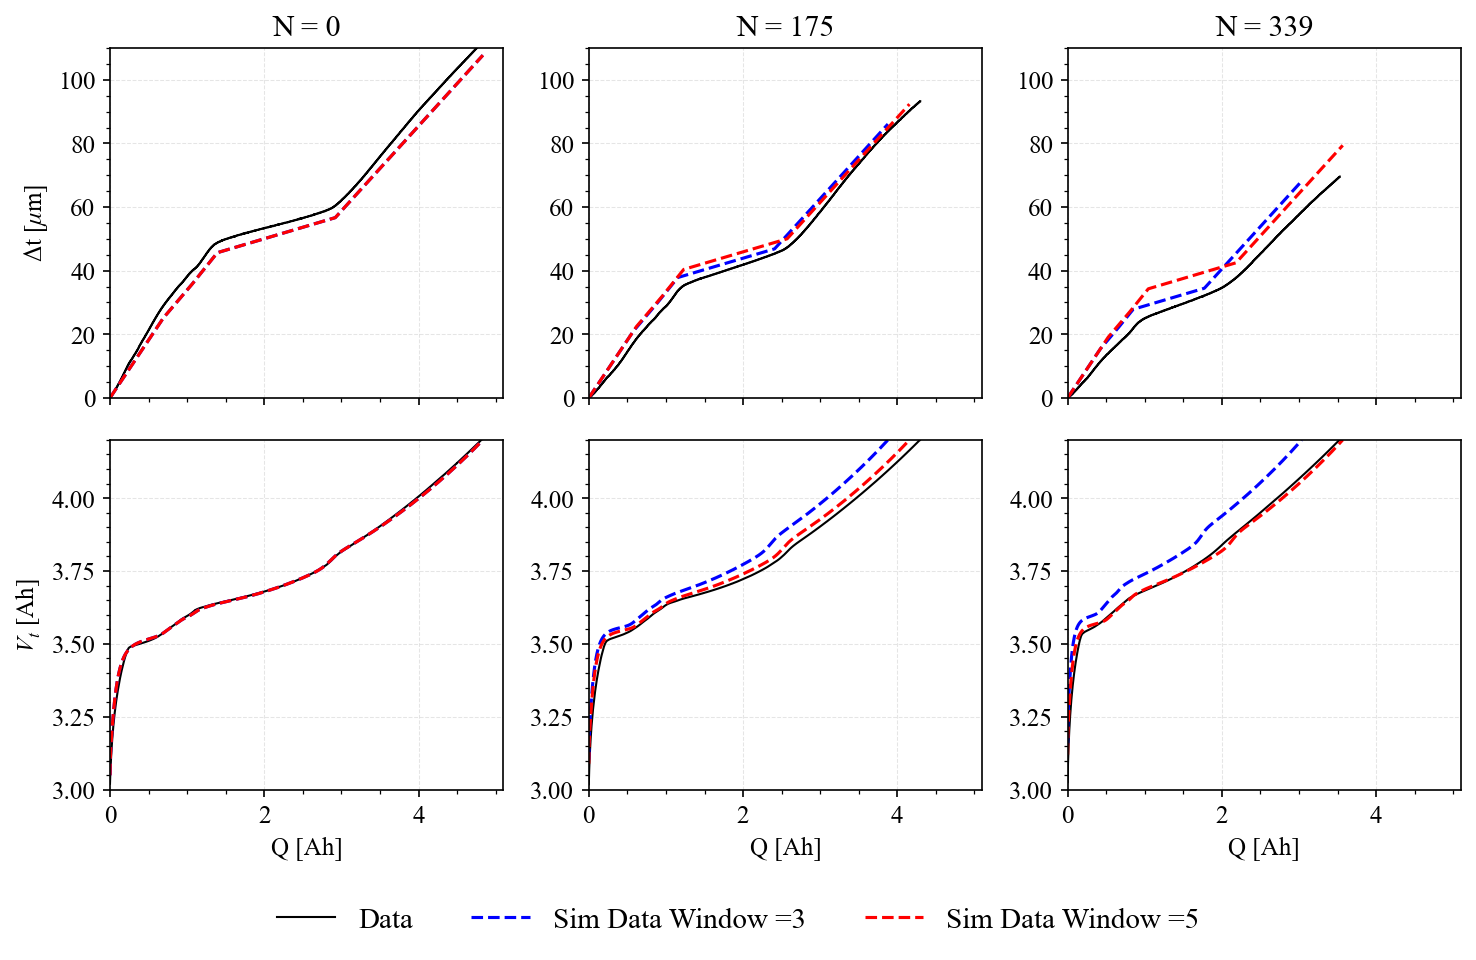

In [89]:
i = 0
rmse_V_l = []
rmse_E_l = []
max_V_l = []
max_E_l = []
fig, axes = plt.subplots(2,3,figsize=(10,6))
# for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
for cyc_no in range(len(N)):
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    # Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp(cyc_no,all_sumvars_dict,dfo)
    # Q_p,Vt_p,exp_p,rmse_V_p,rmse_E_p,max_V_p,max_E_p = rev_exp(cyc_no,dfe,dfo)
    # rmse_V_l = np.append(rmse_V_l,rmse_V)
    # rmse_E_l = np.append(rmse_E_l,rmse_E)
    # max_V_l = np.append(max_V_l,max_V)
    # max_E_l = np.append(max_E_l,max_E)
    if cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
        Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp_2(cyc_no,pred_0,dfo)
        Q_p,Vt_p,exp_p,rmse_V_p,rmse_E_p,max_V_p,max_E_p = rev_exp_2(cyc_no,pred_1,dfo)
        rmse_V_l = np.append(rmse_V_l,rmse_V)
        rmse_E_l = np.append(rmse_E_l,rmse_E)
        max_V_l = np.append(max_V_l,max_V)
        max_E_l = np.append(max_E_l,max_E)
        ax1 = axes.flat[i]
        ax1.plot(dfo['Q'],dfo['E']-dfo['E'].iloc[0],'k',linewidth=1)
        ax1.plot(Q,exp,'b--',linewidth=1.5)
        ax1.plot(Q_p,exp_p,'r--',linewidth=1.5)
        ax1.set_ylim([0,110])
        ax1.set_xlim([0,5.1])
        ax1.set_xticklabels([])
        ax1.set_title('N = {}'.format(N[cyc_no]))
        # ax1.text(0.1,0.9,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax1.transAxes)
        ax2 = axes.flat[i+3]
        ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
        ax2.plot(Q,Vt,'b--',linewidth=1.5)
        ax2.plot(Q_p,Vt_p,'r--',linewidth=1.5)
        ax2.set_ylim([3,4.2])
        ax2.set_xlim([0,5.1])
        ax2.set_xlabel('Q [Ah]')
        # ax2.text(0.5,0.2,f'RMSE_s: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
        if i ==0:
            ax2.set_ylabel('$V_t$ [Ah]')
            ax1.set_ylabel('$\Delta$t [$\mu$m]')
        i+=1
# fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
fig.legend(["Data"]+["Sim Data Window =3"]+["Sim Data Window =5"], loc="lower center",bbox_to_anchor=[0.5, -0.08], ncol=3, fontsize=14)
plt.savefig(fig_DIR +'comp_sim_cell_'+cell_no+'.png')

In [ ]:
N_0[5]

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
ic=0
sim_des = "ic_"+str(ic)
df_x = pd.read_csv(res_DIR + "fit_train_pred_"+sim_des+".csv").drop(['Unnamed: 0'],axis=1)
ax.plot(df_x['train_len'],df_x['obj_full'],'x-',color=colors[ic])
ax.set_title('Norm of Pred Error')
ax.set_xlabel('Training Length')
fig.tight_layout()    
fig.savefig(fig_DIR +'ECS_fig3'+'.png',bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
for ic in range(0,4):
    sim_des = "ic_"+str(ic)
    df_x = pd.read_csv(res_DIR + "fit_train_pred_"+sim_des+".csv").drop(['Unnamed: 0'],axis=1)
    ax.plot(df_x['train_len'],df_x['obj_full'],'x-',color=colors[ic])
    ax.set_title('Norm of Error with Weights')
    ax.set_xlabel('Training Length')
fig.legend(["ic = 0","ic = 1","ic = 2","ic = 3"],ncol=4,loc='lower center',bbox_to_anchor=[0.5,-0.05])
fig.tight_layout()    
fig.savefig(fig_DIR +'norm_obj_all_ic'+'.png',bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(6,3))
for ic in range(0,4):
    sim_des = "ic_"+str(ic)
    df_x = pd.read_csv(res_DIR + "fit_train_pred_"+sim_des+".csv").drop(['Unnamed: 0'],axis=1)
    ax1 = axes.flat[0]
    ax1.plot(df_x['train_len'],df_x['x_0']*blam_p[ic],'x-',color=colors[ic])
    ax1.plot(df_x['train_len'][0],blam_p[ic],'v',color=colors[ic],label='_nolegend_')
    # ax1.set_xticks([])
    ax1.set_title(r'$\beta_{LAM}^+$')
    ax2 = axes.flat[1]
    ax2.plot(df_x['train_len'],df_x['x_1']*blam_n[ic],'x-',color=colors[ic])
    ax2.plot(df_x['train_len'][0],blam_n[ic],'v',color=colors[ic],label='_nolegend_')
    ax2.set_title(r'$\beta_{LAM}^-$')
    ax3 = axes.flat[2]
    ax3.plot(df_x['train_len'],df_x['x_2']*k_sei[ic],'x-',color=colors[ic])
    ax3.plot(df_x['train_len'][0],k_sei[ic],'v',color=colors[ic],label='_nolegend_')
    ax3.set_title(r'$\kappa_{SEI}$')
    ax2.set_xlabel('Training Length')
fig.tight_layout()  
fig.legend(["ic = 0","ic = 1","ic = 2","ic = 3"],ncol=2,loc='lower center',bbox_to_anchor=[0.5,-0.1])
# fig.savefig(fig_DIR +'ECS_fig2'+'.png',bbox_inches='tight')

In [ ]:
ic =0
sim_des = "ic_0"
df_x = pd.read_csv(res_DIR + "fit_train_pred_"+sim_des+".csv").drop(['Unnamed: 0'],axis=1)
df_x
blam_p = [2e-2/3600, 4e-6, 1e-5,1e-6]
blam_n = [2e-1/3600, 3e-5, 2e-5,7e-5]
k_sei= [1.6e-16,1.5e-16,1.7e-16,1.3e-16]
colors = ['b','r','g','y']
sim_des = "acc_ic_0"
df_y = pd.read_csv(res_DIR + "fit_train_pred_"+sim_des+".csv").drop(['Unnamed: 0'],axis=1)

In [ ]:
n1 = 2
print(df_x['train_len'].iloc[n1])
print(df_x['x_0'].iloc[n1]*blam_p[ic])
print(df_x['x_1'].iloc[n1]*blam_n[ic])
print(df_x['x_2'].iloc[n1]*k_sei[ic])

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(6,3))
ax1 = axes.flat[0]
ax2 = axes.flat[1]
ax3 = axes.flat[2]
ax1.plot(df_x['train_len'].tail(1),8.357e-6,'k*')
ax2.plot(df_x['train_len'].tail(1),5.803e-5,'k*',label='_nolegend_')
ax3.plot(df_x['train_len'].tail(1),1.683e-16,'k*',label='_nolegend_')
ic=0
sim_des = "ic_"+str(ic)
df_x = pd.read_csv(res_DIR + "fit_train_pred_"+sim_des+".csv").drop(['Unnamed: 0'],axis=1)
ax1.plot(df_x['train_len'],df_x['x_0']*blam_p[ic],'bx-')
ax1.plot(df_y['train_len'],df_y['x_0']*blam_p[ic],'rv')
# ax1.set_xticks([])
ax1.set_title(r'$\beta_{LAM}^+$')
ax2.plot(df_x['train_len'],df_x['x_1']*blam_n[ic],'bx-')
ax2.plot(df_y['train_len'],df_y['x_1']*blam_n[ic],'rv')
ax2.set_title(r'$\beta_{LAM}^-$')
ax3.plot(df_x['train_len'],df_x['x_2']*k_sei[ic],'x-',color=colors[ic])
ax3.set_title(r'$\kappa_{SEI}$')
ax2.set_xlabel('Training Length')
fig.tight_layout()  
fig.legend(["ACC","ECS tuning all 3",r"ECS tuning only $ \beta $"],ncol=3,loc='lower center',bbox_to_anchor=[0.5,-0.1])
fig.savefig(fig_DIR +'ECS_ACC'+'.png',bbox_inches='tight')